# Datasci210 - Optimizing Investment Portfolio to Adapt to Regime Change
### Irene Na

In [1]:
!pip install --upgrade wrds --quiet
!pip install  --upgrade openpyxl -- quiet

ERROR: Could not find a version that satisfies the requirement quiet (from versions: none)
ERROR: No matching distribution found for quiet


In [137]:
import wrds
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

In [3]:
import openpyxl
print(openpyxl.__version__) 

3.1.5


## Utile functions

In [4]:
def check_na_by_col(df, df_name, figsize=(8,4), rotate_x = False):
    (100*df.apply(lambda x: sum(x.isnull()))/len(df)).rename('Percentage of Missing Value by Columns').sort_values(ascending=False).to_frame()\
    .plot(title=f'{df_name} % of Missing Value by Columns', figsize=figsize)
    if rotate_x:
        plt.xticks(rotation=45)
    plt.show()

## Preparation

In [5]:
# Setting working directory for saving files
print(f'current directory is before change: \n{os.getcwd()}')
current_file_path = r'C:\Mine\U.S.-2019\NPB living - 2 - related\School-part time\Berkeley-202308\MIDS classes\210-Capstone\Project-related\code-IN'
os.chdir(current_file_path)
print(f'current directory is after change: \n{os.getcwd()}')

current directory is before change: 
c:\Mine\U.S.-2019\NPB living - 2 - related\School-part time\Berkeley-202308\MIDS classes\210-Capstone\Project-related\code-IN
current directory is after change: 
C:\Mine\U.S.-2019\NPB living - 2 - related\School-part time\Berkeley-202308\MIDS classes\210-Capstone\Project-related\code-IN


In [85]:
# connect to WRDS
wrds_db = wrds.Connection()

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


## Load the data from storage if previously saved

In [9]:
# Data before EDA
# Load from previously saved files if saved before
with open('./data-used/char_data.pkl','rb') as f:
    char_data = pickle.load(f)

# Load from previously saved files if saved before
with open('./data-used/sp500_crsp.pkl','rb') as f:
    sp500_crsp = pickle.load(f)

with open('./data-used/sp500_crsp_ccm.pkl','rb') as f:
    sp500_crsp_ccm = pickle.load(f)

with open('./data-used/sp500_comb.pkl','rb') as f:
    sp500_comb = pickle.load(f)

# loading important params if decide to skipping all the download and merge cells
#IN: second version where the first five factors are based on paper
char_chosen =['market_equity','be_me','at_gr1','ope_be','ret_12_1', # FF-5-factor
              'ret_6_1','ret_3_1', # other mmt
              'ret_60_12', 'ret_1_0'] # reversal
','.join(map(str, char_chosen))

# Data post EDA
with open('./data-used/data_useful_info_dic.pkl','rb') as f:
    data_useful_info_dic = pickle.load(f)

with open('./data-used/sp500_used.pkl','rb') as f:
    sp500_used = pickle.load(f)


'market_equity,be_me,at_gr1,ope_be,ret_12_1,ret_6_1,ret_3_1,ret_60_12,ret_1_0'

## Downloading the JKP data (Firm Characteristic Data) from WRDS

### Total information scope from JKP data

In [86]:
#downloading and extracting list of developed countries
countries = pd.read_excel('https://github.com/bkelly-lab/ReplicationCrisis/raw/master/GlobalFactors/Country%20Classification.xlsx')
countries_rel = countries[countries['msci_development'] == 'developed']['excntry'].tolist()
display(countries_rel[:10])
print(f'The entire file has {len(countries_rel)} countries')

#downloading and extracting list of characteristics
chars = pd.read_excel('https://github.com/bkelly-lab/ReplicationCrisis/raw/master/GlobalFactors/Factor%20Details.xlsx')
chars_rel = chars[chars['abr_jkp'].notna()]['abr_jkp'].tolist()
display(chars_rel[:5])
print(f'The totoal file has {len(chars_rel)} factors calculated')

['USA', 'JPN', 'HKG', 'GBR', 'CAN', 'AUS', 'DEU', 'FRA', 'SWE', 'CHE']

The entire file has 23 countries


['niq_su', 'ret_6_1', 'ret_12_1', 'saleq_su', 'tax_gr1a']

The totoal file has 153 factors calculated


In [87]:
# char_chosen =['at_me','ope_be','at_be', 'ret_6_1','ret_12_1','ret_3_1','ret_9_1','ret_12_7',
#               'ret_60_12', 'ret_1_0']  #IN: first version based on my understanding

#IN: second version where the first five factors are based on paper
char_chosen =['market_equity','be_me','at_gr1','ope_be','ret_12_1', # FF-5-factor
              'ret_6_1','ret_3_1', # other mmt
              'ret_60_12', 'ret_1_0'] # reversal
','.join(map(str, char_chosen))

'market_equity,be_me,at_gr1,ope_be,ret_12_1,ret_6_1,ret_3_1,ret_60_12,ret_1_0'

In [88]:
', '.join("'" + str(item) + "'" for item in char_chosen)

"'market_equity', 'be_me', 'at_gr1', 'ope_be', 'ret_12_1', 'ret_6_1', 'ret_3_1', 'ret_60_12', 'ret_1_0'"

### Extract relevant data

In [89]:
start_time = '2000-01-01'
cty_chosen = ['USA']

sql_query= f"""
          SELECT id, eom, excntry, gvkey, permno, size_grp, me, ret_exc_lead1m, {','.join(map(str, char_chosen))}
                   FROM contrib.global_factor
                   WHERE common=1 and exch_main=1 and primary_sec=1 and obs_main=1 and
                   excntry in ({','.join("'"+str(x)+"'" for x in cty_chosen)}) and eom>=CAST('{start_time}' AS DATE)
          """
char_data = wrds_db.raw_sql(sql_query)

In [90]:
char_data[~(char_data['ret_exc_lead1m'].isnull())][['eom','ret_exc_lead1m','be_me']]

,eom,ret_exc_lead1m,be_me
5,2000-01-31,-0.504295,NaN
6,2000-01-31,-0.333750,NaN
8,2000-01-31,0.126942,0.240062
10,2000-01-31,-0.069310,0.337988
12,2000-01-31,-0.045962,0.169271
...,...,...,...
488791,2023-07-31,-0.039499,0.056613
488792,2023-08-31,-0.034723,0.058664
488793,2023-09-30,-0.202061,0.060411
488794,2023-10-31,0.190955,0.080084


Char data shape:


(1488797, 17)

Date range and frequency:


array([datetime.date(2000, 1, 31), datetime.date(2000, 2, 29),
       datetime.date(2000, 3, 31), datetime.date(2000, 4, 30),
       datetime.date(2000, 5, 31)], dtype=object)

array([datetime.date(2023, 11, 30), datetime.date(2023, 12, 31),
       datetime.date(2024, 1, 31), datetime.date(2024, 2, 29),
       datetime.date(2024, 3, 31)], dtype=object)

Index(['id', 'eom', 'excntry', 'gvkey', 'permno', 'size_grp', 'me',
       'ret_exc_lead1m', 'market_equity', 'be_me', 'at_gr1', 'ope_be',
       'ret_12_1', 'ret_6_1', 'ret_3_1', 'ret_60_12', 'ret_1_0'],
      dtype='object')

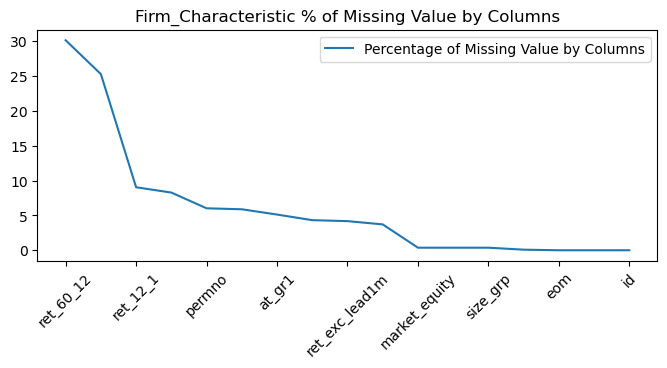

5111.776632302405

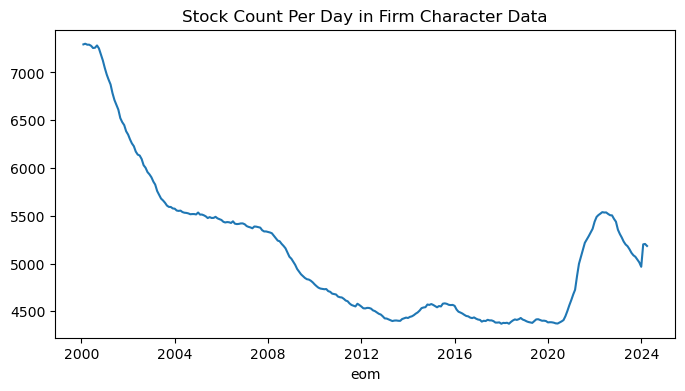

In [106]:
# Char Data checking
print('Char data shape:')
display(char_data.shape)

print('Date range and frequency:')
display(char_data['eom'].unique()[:5])
display(char_data['eom'].unique()[-5:])

# Char columns:
display(char_data.columns)

# Check on missing value
check_na_by_col(char_data, 'Firm_Characteristic', figsize=(8,3), rotate_x=True)

# Average stock per day:
display(char_data.groupby('eom')['gvkey'].count().mean())

# Stock per day chart over time
char_data.groupby('eom')['gvkey'].count().rename('Stock_count_per_day')\
    .plot(title='Stock Count Per Day in Firm Character Data', figsize=(8,4))
plt.show()

In [107]:
char_data.head()

,id,eom,excntry,gvkey,permno,size_grp,me,ret_exc_lead1m,market_equity,be_me,at_gr1,ope_be,ret_12_1,ret_6_1,ret_3_1,ret_60_12,ret_1_0
0,100506301.0,2000-01-31,USA,005063,NaN,mega,13432.4775,NaN,13432.4775,0.147023,0.203907,NaN,1.394366,0.873278,0.579559,1.086030,-0.091912
1,101241801.0,2000-01-31,USA,012418,NaN,small,739.9630,NaN,739.9630,NaN,0.265597,NaN,NaN,NaN,NaN,NaN,NaN
2,106619801.0,2000-01-31,USA,066198,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,102859101.0,2000-01-31,USA,028591,NaN,nano,17.6505,NaN,17.6505,NaN,-0.015385,NaN,-0.175463,0.130435,0.130435,-0.892352,0.076923
4,100104301.0,2000-01-31,USA,001043,NaN,nano,3.5600,NaN,3.5600,NaN,-0.075133,NaN,-0.625000,-0.485714,0.000000,-0.769697,0.111111


In [109]:
# Save this data locally for later use
with open('./data-used/char_data.pkl','wb') as f:
    pickle.dump(char_data, f)

# char_data.to_csv('./data-used/char_data.csv')

## Download S&P500 constituents From CRSP and Compustat

### Get S&P constituents in-index date range and respective return

In [111]:
start_time_sp = start_time
# IN: crsp.msp500list is monthly data, crsp.dsp500list is daily data; similarly crsp.msp is monthly data; crsp.dsp is daily data

sp500_daily = wrds_db.raw_sql(f"""
                        select a.*, b.date, b.ret, b.vol
                        from crsp.dsp500list as a,
                        crsp.dsf as b
                        where a.permno=b.permno
                        and b.date >= a.start and b.date<= a.ending
                        and b.date>=CAST('{start_time_sp}' AS DATE)
                        order by date;
                        """, date_cols=['start', 'ending', 'date'])

data shape is:


(3028551, 6)


Average daily stock count:


permno    501.6649
dtype: float64


Average time count per year:


251.54166666666666

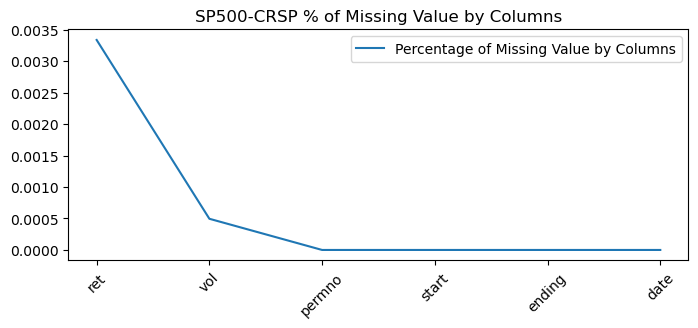

501.66489978466126

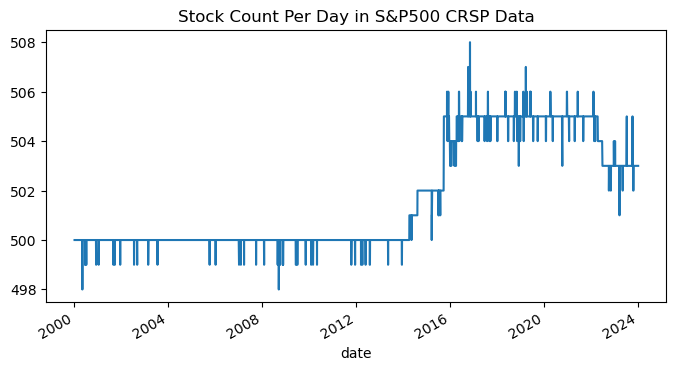

,permno,start,ending,date,ret,vol
0,64936,1983-05-20,2023-12-29,2000-01-03,-0.028662,1036700.0
1,24205,1976-07-01,2023-12-29,2000-01-03,-0.036496,512100.0
2,60441,1997-08-07,2000-05-31,2000-01-03,-0.028926,811700.0
3,45751,1987-08-06,2023-12-29,2000-01-03,-0.011757,1083199.0
4,76887,1999-08-02,2008-12-04,2000-01-03,-0.042553,953400.0


In [113]:
print ('data shape is:')
display(sp500_daily.shape)

print ('\nAverage daily stock count:')
display(sp500_daily.groupby('date')[['permno']].count().mean())

print ('\nAverage time count per year:')
display(len(sp500_daily.groupby('date')[['permno']].count())/(2024-2000))

# Check on missing value
check_na_by_col(sp500_daily, 'SP500-CRSP', figsize=(8,3), rotate_x=True)

# Average stock per day:
display(sp500_daily.groupby('date')['permno'].count().mean())

# Stock per day chart over time
sp500_daily.groupby('date')['permno'].count().rename('Stock_count_per_day')\
    .plot(title='Stock Count Per Day in S&P500 CRSP Data', figsize=(8,4))
plt.show()

display(sp500_daily.head())

## Get Identifier and Descriptive Data From CRSP and Compustat for merges

In [114]:
# Add Other Descriptive Variables from CRSP

mse = wrds_db.raw_sql("""
                        select comnam, ncusip, namedt, nameendt, 
                        permno, shrcd, exchcd, hsiccd, ticker
                        from crsp.msenames
                        """, date_cols=['namedt', 'nameendt'])

# if nameendt is missing then set to today date
mse['nameendt']=mse['nameendt'].fillna(pd.to_datetime('today'))

mse.head()

,comnam,ncusip,namedt,nameendt,permno,shrcd,exchcd,hsiccd,ticker
0,OPTIMUM MANUFACTURING INC,68391610,1986-01-07,1986-12-03,10000,10,3,3990,OMFGA
1,OPTIMUM MANUFACTURING INC,68391610,1986-12-04,1987-03-09,10000,10,3,3990,OMFGA
2,OPTIMUM MANUFACTURING INC,68391610,1987-03-10,1987-06-11,10000,10,3,3990,OMFGA
3,GREAT FALLS GAS CO,39040610,1986-01-09,1993-11-21,10001,11,3,4925,GFGC
4,ENERGY WEST INC,29274A10,1993-11-22,2004-06-09,10001,11,3,4925,EWST


In [115]:
# Merge with SP500 universe data
sp500_crsp = pd.merge(sp500_daily, mse, how = 'left', on = 'permno')

# Impose the date range restrictions
sp500_crsp = sp500_crsp.loc[(sp500_crsp.date>=sp500_crsp.namedt) \
                            & (sp500_crsp.date<=sp500_crsp.nameendt)]
sp500_crsp.head()

,permno,start,ending,date,ret,vol,comnam,ncusip,namedt,nameendt,shrcd,exchcd,hsiccd,ticker
0,64936,1983-05-20,2023-12-29,2000-01-03,-0.028662,1036700.0,DOMINION RESOURCES INC VA,25747010,1983-06-02,2000-01-30,11,1,1311,D
13,24205,1976-07-01,2023-12-29,2000-01-03,-0.036496,512100.0,F P L GROUP INC,30257110,1984-12-12,2002-01-01,11,1,4911,FPL
23,60441,1997-08-07,2000-05-31,2000-01-03,-0.028926,811700.0,MIRAGE RESORTS INC,60462E10,1991-06-03,2000-05-31,11,1,7999,MIR
26,45751,1987-08-06,2023-12-29,2000-01-03,-0.011757,1083199.0,MARSH & MCLENNAN COS INC,57174810,1975-05-22,2002-01-01,11,1,6411,MMC
35,76887,1999-08-02,2008-12-04,2000-01-03,-0.042553,953400.0,ALLIED WASTE INDUSTRIES INC,01958930,1998-12-30,2002-01-01,11,1,4953,AW


In [116]:
print ('data shape is:')
display(sp500_crsp.shape)
print (f'Entry number changed by: {sp500_crsp.shape[0]-sp500_daily.shape[0]}')

data shape is:


(3028551, 14)

Entry number changed by: 0


In [117]:
# Linking with Compustat through CCM

ccm=wrds_db.raw_sql("""
                  select gvkey, liid as iid, lpermno as permno, linktype, linkprim, 
                  linkdt, linkenddt
                  from crsp.ccmxpf_linktable
                  where substr(linktype,1,1)='L'
                  and (linkprim ='C' or linkprim='P')
                  """, date_cols=['linkdt', 'linkenddt'])

# if linkenddt is missing then set to today date
ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today'))

In [118]:
# Merge the CCM data with S&P500 data
# First just link by matching PERMNO
sp500_crsp_ccm = pd.merge(sp500_crsp, ccm, how='left', on=['permno'])

# Then set link date bounds
sp500_crsp_ccm = sp500_crsp_ccm.loc[(sp500_crsp_ccm['date']>=sp500_crsp_ccm['linkdt'])\
                        &(sp500_crsp_ccm['date']<=sp500_crsp_ccm['linkenddt'])]

sp500_crsp_ccm.head()

,permno,start,ending,date,ret,vol,comnam,ncusip,namedt,nameendt,shrcd,exchcd,hsiccd,ticker,gvkey,iid,linktype,linkprim,linkdt,linkenddt
0,64936,1983-05-20,2023-12-29,2000-01-03,-0.028662,1036700.0,DOMINION RESOURCES INC VA,25747010,1983-06-02,2000-01-30,11,1,1311,D,004029,01,LC,P,1983-06-02,2025-01-31 15:01:07.016575
2,24205,1976-07-01,2023-12-29,2000-01-03,-0.036496,512100.0,F P L GROUP INC,30257110,1984-12-12,2002-01-01,11,1,4911,FPL,004517,01,LC,P,1962-01-31,2025-01-31 15:01:07.016575
3,60441,1997-08-07,2000-05-31,2000-01-03,-0.028926,811700.0,MIRAGE RESORTS INC,60462E10,1991-06-03,2000-05-31,11,1,7999,MIR,005211,01,LU,C,1978-08-15,2000-06-30 00:00:00.000000
4,45751,1987-08-06,2023-12-29,2000-01-03,-0.011757,1083199.0,MARSH & MCLENNAN COS INC,57174810,1975-05-22,2002-01-01,11,1,6411,MMC,007065,01,LU,P,1968-02-16,2025-01-31 15:01:07.016575
5,76887,1999-08-02,2008-12-04,2000-01-03,-0.042553,953400.0,ALLIED WASTE INDUSTRIES INC,01958930,1998-12-30,2002-01-01,11,1,4953,AW,022140,02,LC,P,1991-09-10,2008-12-05 00:00:00.000000


data shape is:


(3021424, 20)

Entry number changed by: -7127


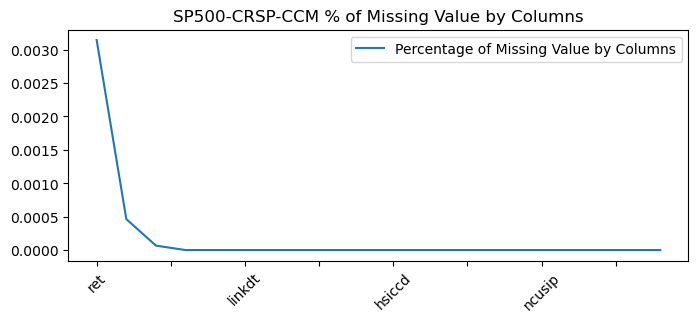

500.48434652973333

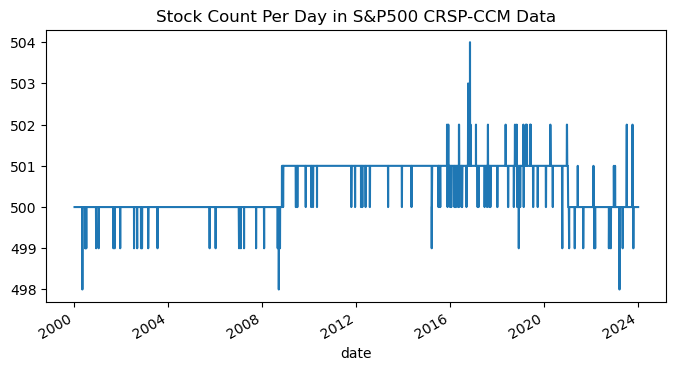

In [119]:
print ('data shape is:')
display(sp500_crsp_ccm.shape)
print (f'Entry number changed by: {sp500_crsp_ccm.shape[0]-sp500_crsp.shape[0]}')

# Check on missing value
check_na_by_col(sp500_crsp_ccm, 'SP500-CRSP-CCM', figsize=(8,3), rotate_x=True)

# Average stock per day:
display(sp500_crsp_ccm.groupby('date')['permno'].count().mean())

# Stock per day chart over time
sp500_crsp_ccm.groupby('date')['permno'].count().rename('Stock_count_per_day')\
    .plot(title='Stock Count Per Day in S&P500 CRSP-CCM Data', figsize=(8,4))
plt.show()

## Merge S&P500 Universe CRSP, Compustat Data with Firm Characteristic data

In [120]:
char_data.columns

Index(['id', 'eom', 'excntry', 'gvkey', 'permno', 'size_grp', 'me',
       'ret_exc_lead1m', 'market_equity', 'be_me', 'at_gr1', 'ope_be',
       'ret_12_1', 'ret_6_1', 'ret_3_1', 'ret_60_12', 'ret_1_0'],
      dtype='object')

#### Prepare char_data to be merged

In [121]:
# IN - get the index we need for char_data from sp500
sp500_crsp_ccm_adj = sp500_crsp_ccm.copy().drop_duplicates(subset=['date','permno'])
sp500_crsp_ccm_adj = sp500_crsp_ccm_adj.set_index(['date','permno'])
daily_index = pd.date_range(start=sp500_crsp_ccm_adj.index.get_level_values('date').min(),
                            end=sp500_crsp_ccm_adj.index.get_level_values('date').max(),
                            freq='D')

In [122]:
print(f'Before dedup, sp500 dataset has the shape of {sp500_crsp_ccm.shape}')
print(f'After dedup, sp500 dataset has the shape of {sp500_crsp_ccm_adj.shape}')

Before dedup, sp500 dataset has the shape of (3021424, 20)
After dedup, sp500 dataset has the shape of (3018361, 18)


In [32]:
### IN: if we look to reindex sp500_crsp_ccm to daily frequency ourselves (which we don't actually need)
## method 1 
# sp500_crsp_ccm_adj = sp500_crsp_ccm_adj.reindex(pd.MultiIndex\
#                                                 .from_product([daily_index, sp500_crsp_ccm_adj.index.get_level_values('permno').unique()],
#                                                               names=['date','permno']))\
#                                                               .groupby('permno').ffill().reset_index()

## method 2
# sp500_crsp_ccm_adj = sp500_crsp_ccm_adj.set_index(['date','permno'])\
#     .unstack('permno').asfreq('D').ffill().stack('permno', future_stack=True).reset_index()

In [123]:
# IN: Use sp500_crsp_ccm_adj's extended index with daily frequency (note not BD) to reindex char_data
char_data_adj = char_data.copy()[['permno','eom']+char_chosen+['ret_exc_lead1m']].dropna(subset=['permno'])
char_data_adj['date'] = pd.to_datetime(char_data_adj['eom'])

char_data_adj = char_data_adj.set_index(['date','permno'])\
    .reindex(pd.MultiIndex.from_product([daily_index, sp500_crsp_ccm_adj.index.get_level_values('permno').unique()],
                                                              names=['date','permno']))\
                                                              .groupby('permno').ffill().reset_index()

In [124]:
# IN: check data - if reindex and forward fill is done correctly
# IN: check the head
char_data_adj.groupby(['permno'])[['date']+char_chosen]\
    .apply(lambda x: x).droplevel(1).reset_index().head(60)

,permno,date,market_equity,be_me,at_gr1,ope_be,ret_12_1,ret_6_1,ret_3_1,ret_60_12,ret_1_0
0,10078,2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10078,2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10078,2000-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10078,2000-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10078,2000-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,10078,2000-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,10078,2000-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,10078,2000-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,10078,2000-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10078,2000-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
# check the tail
char_data_adj.groupby(['permno'])[['date']+char_chosen]\
    .apply(lambda x: x).droplevel(1).reset_index().tail(60)

,permno,date,market_equity,be_me,at_gr1,ope_be,ret_12_1,ret_6_1,ret_3_1,ret_60_12,ret_1_0
9296422,93436,2023-10-31,638454.481998,0.080084,0.322245,0.326384,0.099675,0.522853,-0.064353,9.118284,-0.197346
9296423,93436,2023-11-01,638454.481998,0.080084,0.322245,0.326384,0.099675,0.522853,-0.064353,9.118284,-0.197346
9296424,93436,2023-11-02,638454.481998,0.080084,0.322245,0.326384,0.099675,0.522853,-0.064353,9.118284,-0.197346
9296425,93436,2023-11-03,638454.481998,0.080084,0.322245,0.326384,0.099675,0.522853,-0.064353,9.118284,-0.197346
9296426,93436,2023-11-04,638454.481998,0.080084,0.322245,0.326384,0.099675,0.522853,-0.064353,9.118284,-0.197346
9296427,93436,2023-11-05,638454.481998,0.080084,0.322245,0.326384,0.099675,0.522853,-0.064353,9.118284,-0.197346
9296428,93436,2023-11-06,638454.481998,0.080084,0.322245,0.326384,0.099675,0.522853,-0.064353,9.118284,-0.197346
9296429,93436,2023-11-07,638454.481998,0.080084,0.322245,0.326384,0.099675,0.522853,-0.064353,9.118284,-0.197346
9296430,93436,2023-11-08,638454.481998,0.080084,0.322245,0.326384,0.099675,0.522853,-0.064353,9.118284,-0.197346
9296431,93436,2023-11-09,638454.481998,0.080084,0.322245,0.326384,0.099675,0.522853,-0.064353,9.118284,-0.197346


### Merge sp500 data with reindexed firm characteristic data

In [126]:
#IN: note: we still want to keep sp500_crsp_ccm's original date frequency (trade date), so use it as left dataframe, and left join
sp500_comb = pd.merge(sp500_crsp_ccm, char_data_adj, on=['date','permno'], how='left').sort_values(by=['permno','date']).reset_index()

In [ ]:
# IN: check unique dates
sp500_comb[['date','ret_exc_lead1m']][~(sp500_comb['ret_exc_lead1m'].isnull())]['date'].unique()

<DatetimeArray>
['2000-01-31 00:00:00', '2000-02-01 00:00:00', '2000-02-02 00:00:00',
 '2000-02-03 00:00:00', '2000-02-04 00:00:00', '2000-02-07 00:00:00',
 '2000-02-08 00:00:00', '2000-02-09 00:00:00', '2000-02-10 00:00:00',
 '2000-02-11 00:00:00',
 ...
 '2023-12-15 00:00:00', '2023-12-18 00:00:00', '2023-12-19 00:00:00',
 '2023-12-20 00:00:00', '2023-12-21 00:00:00', '2023-12-22 00:00:00',
 '2023-12-26 00:00:00', '2023-12-27 00:00:00', '2023-12-28 00:00:00',
 '2023-12-29 00:00:00']
Length: 6018, dtype: datetime64[ns]

In [127]:
print ('The ratio of non-na entres/total entries after joining (post forwrad fill) is:')
print (len(sp500_comb[['date','be_me']][~sp500_comb['be_me'].isnull()])/len(sp500_comb['be_me']))

The ratio of non-na entres/total entries after joining (post forwrad fill) is:
0.9642423572461197


In [128]:
# IN: checking forward fill results
sp500_comb.head(45)

,index,permno,start,ending,date,ret,vol,comnam,ncusip,namedt,...,market_equity,be_me,at_gr1,ope_be,ret_12_1,ret_6_1,ret_3_1,ret_60_12,ret_1_0,ret_exc_lead1m
0,14,10078,1992-08-20,2010-01-28,2000-01-03,-0.012107,15270527.0,SUN MICROSYSTEMS INC,86681010,1986-03-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,824,10078,1992-08-20,2010-01-28,2000-01-04,-0.062092,21098710.0,SUN MICROSYSTEMS INC,86681010,1986-03-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1428,10078,1992-08-20,2010-01-28,2000-01-05,0.001742,30073258.0,SUN MICROSYSTEMS INC,86681010,1986-03-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1805,10078,1992-08-20,2010-01-28,2000-01-06,-0.053913,22741999.0,SUN MICROSYSTEMS INC,86681010,1986-03-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2084,10078,1992-08-20,2010-01-28,2000-01-07,0.056985,20450260.0,SUN MICROSYSTEMS INC,86681010,1986-03-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2914,10078,1992-08-20,2010-01-28,2000-01-10,0.094783,26428053.0,SUN MICROSYSTEMS INC,86681010,1986-03-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3429,10078,1992-08-20,2010-01-28,2000-01-11,-0.011914,25523777.0,SUN MICROSYSTEMS INC,86681010,1986-03-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3940,10078,1992-08-20,2010-01-28,2000-01-12,-0.043408,15609551.0,SUN MICROSYSTEMS INC,86681010,1986-03-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,4078,10078,1992-08-20,2010-01-28,2000-01-13,0.038656,13256901.0,SUN MICROSYSTEMS INC,86681010,1986-03-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,4783,10078,1992-08-20,2010-01-28,2000-01-14,0.040453,23705224.0,SUN MICROSYSTEMS INC,86681010,1986-03-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [190]:
# IN: for checking (no need to forward fill here anymore)
# sp500_comb.groupby(['permno'])[['date']+char_chosen]\
#     .apply(lambda x: x.sort_values(by='date').ffill()).droplevel(1).reset_index().head(45)

# sp500_comb[char_chosen] = sp500_comb.groupby(['permno'])[['date']+char_chosen+['ret_exc_lead1m']]\
#     .apply(lambda x: x.ffill()).droplevel(1).reset_index()[char_chosen]

data shape is:


(3021424, 32)

Entry number changed by: 0


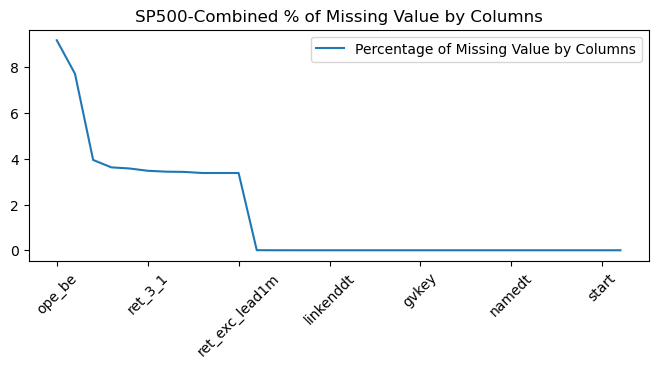

Average number stocks per day is:


500.48434652973333

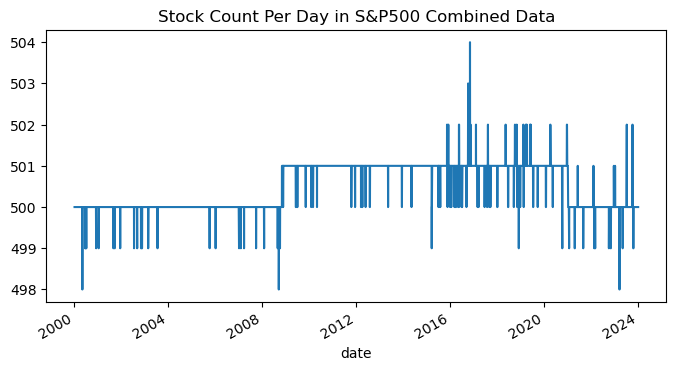

In [129]:
print ('data shape is:')
display(sp500_comb.shape)
print (f'Entry number changed by: {sp500_comb.shape[0]-sp500_crsp_ccm.shape[0]}')

# Check on missing value
check_na_by_col(sp500_comb, 'SP500-Combined', figsize=(8,3), rotate_x=True)

# Average stock per day:
print ('Average number stocks per day is:')
display(sp500_comb.groupby('date')['permno'].count().mean())

# Stock per day chart over time
sp500_comb.groupby('date')['permno'].count().rename('Stock_count_per_day')\
    .plot(title='Stock Count Per Day in S&P500 Combined Data', figsize=(8,4))
plt.show()

In [130]:
# Saving the datasets:
with open('./data-used/sp500_crsp.pkl','wb') as f:
    pickle.dump(sp500_crsp, f)

with open('./data-used/sp500_crsp_ccm.pkl','wb') as f:
    pickle.dump(sp500_crsp_ccm, f)

with open('./data-used/sp500_comb.pkl','wb') as f:
    pickle.dump(sp500_comb, f)

# sp500_crsp.to_csv('./data-used/sp500_crsp.csv')
# sp500_crsp_ccm.to_csv('./data-used/sp500_crsp_ccm.csv')
sp500_comb.to_csv('./data-used/sp500_comb.csv')

## Preliminary EDA

In [10]:
sp500_comb.columns

Index(['index', 'permno', 'start', 'ending', 'date', 'ret', 'vol', 'comnam',
       'ncusip', 'namedt', 'nameendt', 'shrcd', 'exchcd', 'hsiccd', 'ticker',
       'gvkey', 'iid', 'linktype', 'linkprim', 'linkdt', 'linkenddt', 'eom',
       'market_equity', 'be_me', 'at_gr1', 'ope_be', 'ret_12_1', 'ret_6_1',
       'ret_3_1', 'ret_60_12', 'ret_1_0', 'ret_exc_lead1m'],
      dtype='object')

In [174]:
# Important dataset params
useful_columns = ['permno','date','comnam','ncusip','ticker','gvkey','hsiccd','ret','vol','ret_exc_lead1m']+char_chosen
name_map = {'comnam':'company_name',
            'hsiccd':'industry_code',
            'ret':'return',
            'vol':'volume',
            'ret_exc_lead1m':'return_lead1m',
            'be_me':'book_to_equity',
            'at_gr1':'asset_growth',
            'ope_be':'opt_to_book_eq'}

time_columns = ['date']
identifier_columns = [name_map[x] if x in name_map else x for x in ['permno','ncusip','ticker','gvkey']]
categorical_columns = [name_map[x] if x in name_map else x for x in ['comnam','hsiccd']]
numerical_columns = [name_map[x] if x in name_map else x for x in char_chosen + ['ret','vol','ret_exc_lead1m']]

sp500_used = sp500_comb[useful_columns].rename(columns=name_map)

data shape is:


(3021424, 19)

Entry number changed by: 0


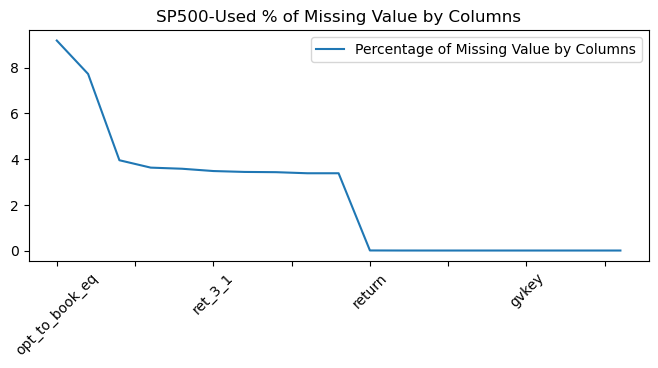

Average number stocks per day is:


500.48434652973333

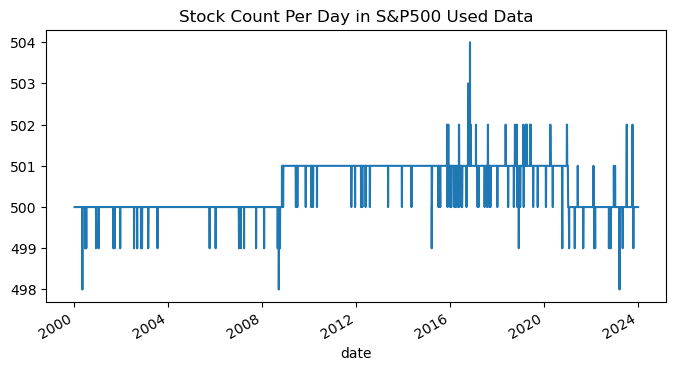

In [46]:
# Overall Checking
print ('data shape is:')
display(sp500_used.shape)
print (f'Entry number changed by: {sp500_used.shape[0]-sp500_comb.shape[0]}')

# Check on missing value
check_na_by_col(sp500_used, 'SP500-Used', figsize=(8,3), rotate_x=True)

# Average stock per day:
print ('Average number stocks per day is:')
display(sp500_used.groupby('date')['permno'].count().mean())

# Stock per day chart over time
sp500_used.groupby('date')['permno'].count().rename('Stock_count_per_day')\
    .plot(title='Stock Count Per Day in S&P500 Used Data', figsize=(8,4))
plt.show()

### Numerical Variables

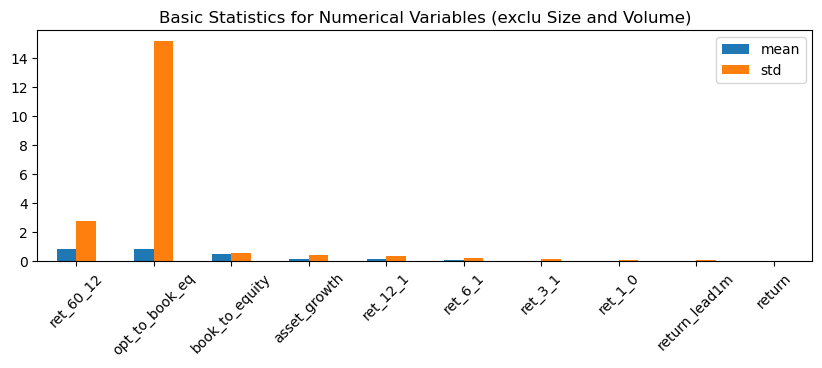

In [47]:
# Basic stats
stats_num = np.round(sp500_used[numerical_columns].describe(),3)
cols_to_drop = ['volume','market_equity']

stats_num.loc[['mean','std'],:].drop(columns=cols_to_drop).T.sort_values(by='mean', ascending=False)\
    .plot(figsize=(10,3), kind='bar')
plt.title('Basic Statistics for Numerical Variables (exclu Size and Volume)')
plt.xticks(rotation=45)
plt.show()

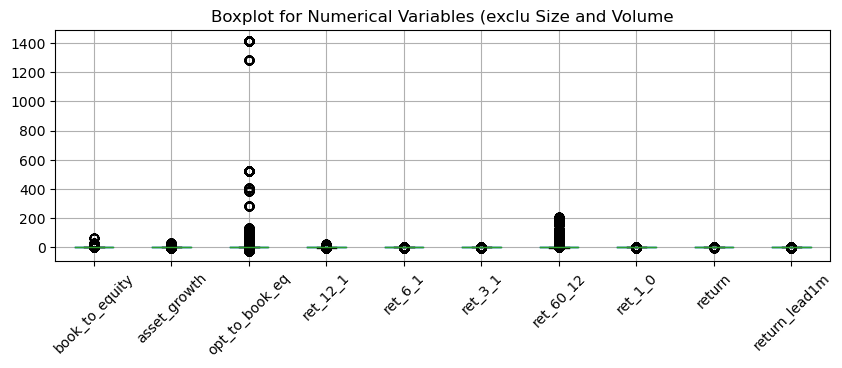

In [48]:
# Boxplot
sp500_used[numerical_columns].drop(columns=cols_to_drop)\
    .boxplot(figsize=(10,3))
plt.title('Boxplot for Numerical Variables (exclu Size and Volume')
plt.xticks(rotation=45)
plt.show()

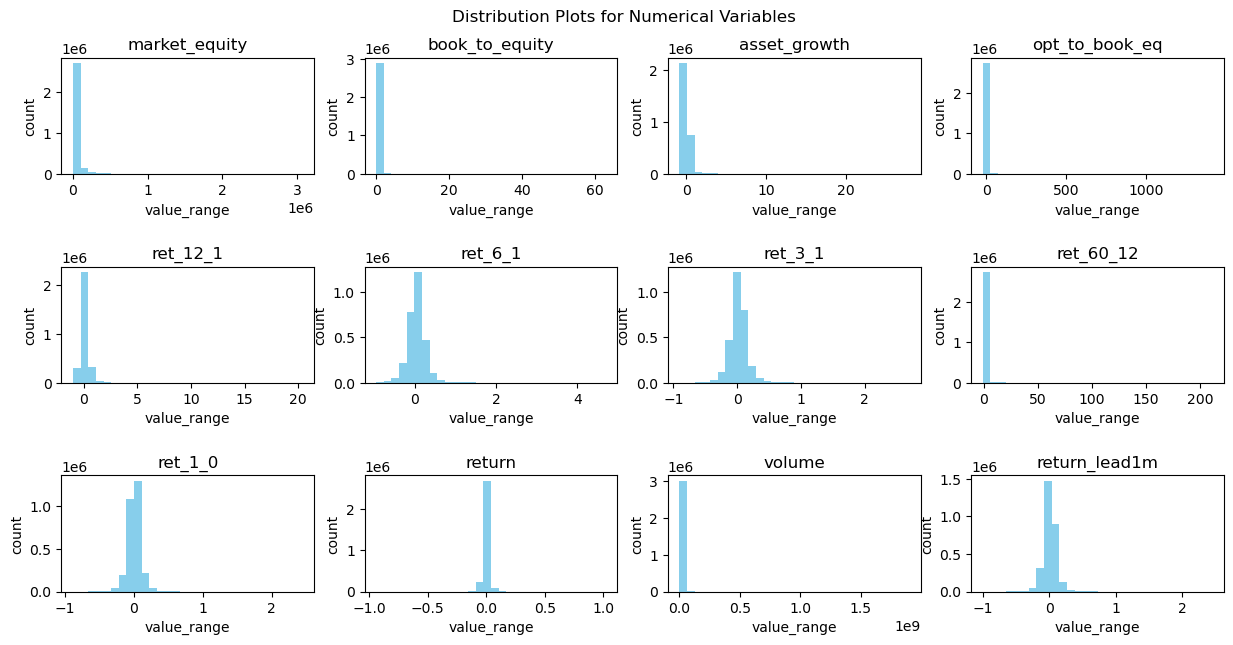

In [49]:
# Value count check
# for col in numerical_columns:
#     display(sp500_used[col].value_counts())

# Distribution check
# cols_to_plot = list(set(numerical_columns)-set(cols_to_drop))
cols_to_plot = numerical_columns
n = len(cols_to_plot)
n_per_row = 4

fig1, ax1 = plt.subplots(n//n_per_row, n_per_row, figsize=(15,6))

for i, col in enumerate(cols_to_plot):
    ax1[i//n_per_row, i%n_per_row].hist(sp500_used[col], color='skyblue', bins=30)
    ax1[i//n_per_row, i%n_per_row].set_title(col)
    ax1[i//n_per_row, i%n_per_row].set_ylabel('count')
    ax1[i//n_per_row, i%n_per_row].set_xlabel('value_range')

plt.suptitle('Distribution Plots for Numerical Variables')
plt.subplots_adjust(top=0.90, bottom=0.01, hspace=0.8)
plt.show()

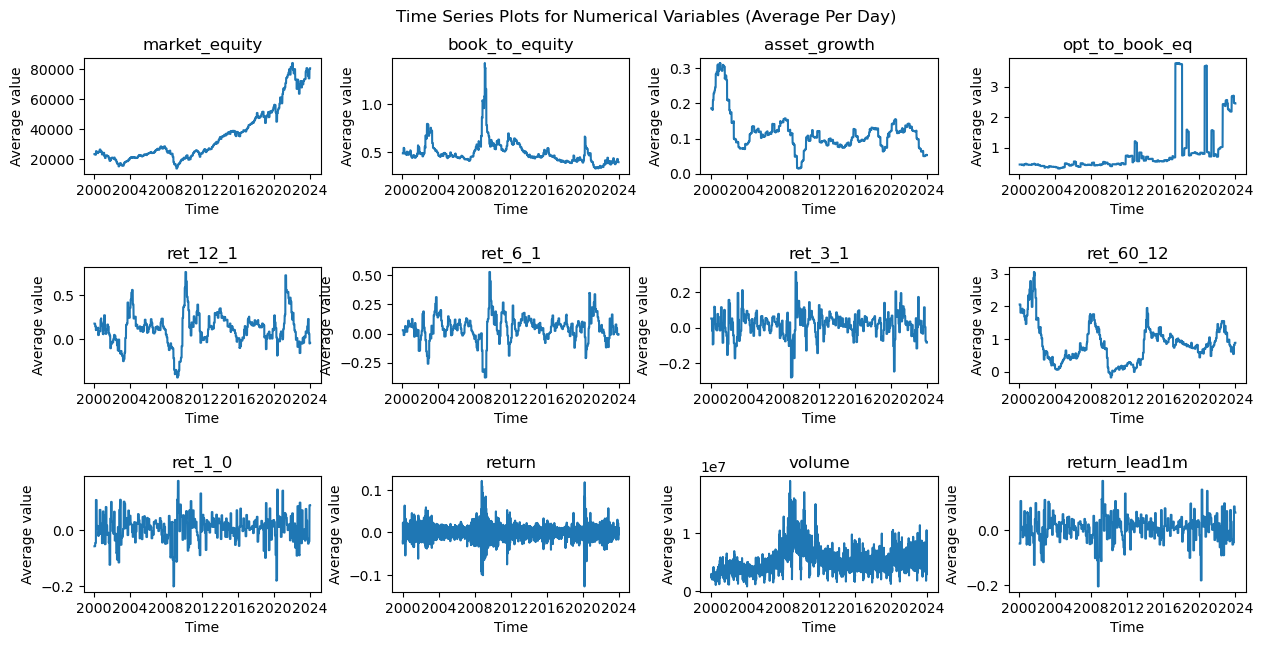

In [51]:
# Time series plot
cols_to_plot = numerical_columns
n = len(cols_to_plot)
n_per_row = 4

fig1, ax1 = plt.subplots(n//n_per_row, n_per_row, figsize=(15,6))

for i, col in enumerate(cols_to_plot):
    t_series = sp500_used.groupby('date')[col].mean()
    ax1[i//n_per_row, i%n_per_row].plot(t_series)
    ax1[i//n_per_row, i%n_per_row].set_title(col)
    ax1[i//n_per_row, i%n_per_row].set_ylabel('Average value')
    ax1[i//n_per_row, i%n_per_row].set_xlabel('Time')

plt.suptitle('Time Series Plots for Numerical Variables (Average Per Day)')
plt.subplots_adjust(top=0.90, bottom=0.01, hspace=0.8, wspace=0.3)
plt.show()

,date,company_name,opt_to_book_eq
491687,2017-05-01,COLGATE PALMOLIVE CO,1417.333333
491688,2017-05-02,COLGATE PALMOLIVE CO,1417.333333
491689,2017-05-03,COLGATE PALMOLIVE CO,1417.333333
491690,2017-05-04,COLGATE PALMOLIVE CO,1417.333333
491691,2017-05-05,COLGATE PALMOLIVE CO,1417.333333
...,...,...,...
2947701,2020-10-26,WESTERN UNION CO,1285.555556
2947702,2020-10-27,WESTERN UNION CO,1285.555556
2947703,2020-10-28,WESTERN UNION CO,1285.555556
2947704,2020-10-29,WESTERN UNION CO,1285.555556


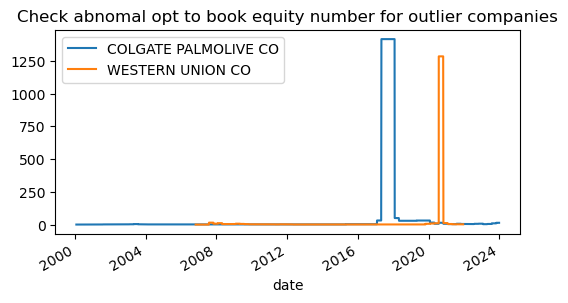

In [135]:
# Check opt_to_book_eq values in 2016 to 2020
t_series = sp500_used.groupby('date')['opt_to_book_eq'].mean()
# t_series[t_series>3].index

sub_period = sp500_used.loc[sp500_used['date'].isin(t_series[t_series>3].index), ['date','company_name','opt_to_book_eq']]
abnormal_comps = sub_period[sub_period['opt_to_book_eq']>1000]['company_name'].unique()

# display(sub_period.loc[sub_period['opt_to_book_eq']==sub_period['opt_to_book_eq'].max()])
# display(sub_period.loc[sub_period['opt_to_book_eq']==sub_period['opt_to_book_eq'].max()]['company_name'].unique())
# display(sub_period['opt_to_book_eq'].max())

display(sub_period.loc[sub_period['company_name'].isin(abnormal_comps)])

sp500_used[sp500_used['company_name'].isin(abnormal_comps)][['date','opt_to_book_eq','company_name']]\
    .groupby(['date','company_name']).last().unstack().droplevel(0, axis=1)\
    .plot(title='Check abnomal opt to book equity number for outlier companies', figsize=(6,3))
plt.legend(loc='upper left')
plt.show()

problematic_period = sub_period.loc[sub_period['opt_to_book_eq']>1000]['date'].unique()

#### Note: upon checking, >1000 can't be right for operating profit to book equity, and it looks abnormal for the company historically as well. Replace this abnormal number with nan, then run the charts again

array([nan])

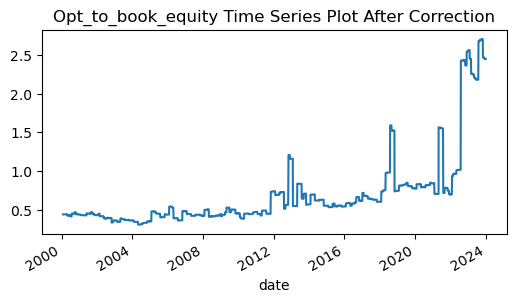

In [136]:
## Correcting outlier:
sp500_used.loc[(sp500_used['company_name'].isin(abnormal_comps))&
               (sp500_used['date'].isin(problematic_period)),'opt_to_book_eq'] = np.nan

# check post correcting
display(sp500_used.loc[(sp500_used['company_name'].isin(abnormal_comps))&
               (sp500_used['date'].isin(problematic_period)),'opt_to_book_eq'].unique())

# check opt_to_book_eq time series (avg)
sp500_used.groupby('date')['opt_to_book_eq'].mean()\
    .plot(title='Opt_to_book_equity Time Series Plot After Correction',
          figsize=(6,3))
plt.show()

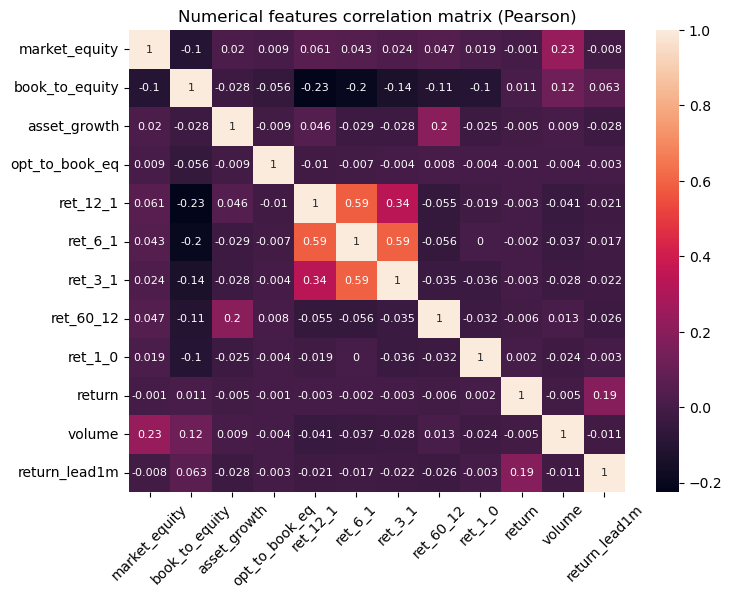

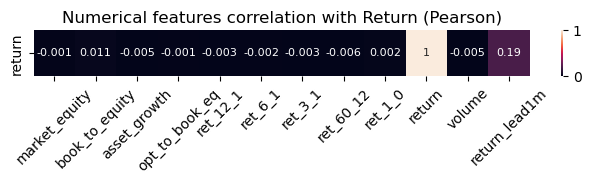

In [148]:
# Numerical Variable's correlation (Pearson) check with 'target variable'

# numerical values' pearson correlation matrix among themselves
cm = np.round(sp500_used[numerical_columns].corr(method='pearson'),3)
plt.figure(figsize=(8,6))
hm = sns.heatmap(cm, annot=True, annot_kws={'size': 8})
plt.title('Numerical features correlation matrix (Pearson)')
plt.xticks(rotation=45)
plt.show()

# if just showing the correlation with return 
plt.figure(figsize=(8,0.6))
hm = sns.heatmap(cm['return'].to_frame().T, annot=True, annot_kws={'size': 8})
plt.title('Numerical features correlation with Return (Pearson)')
plt.xticks(rotation=45)
plt.show()

### Categorical variables

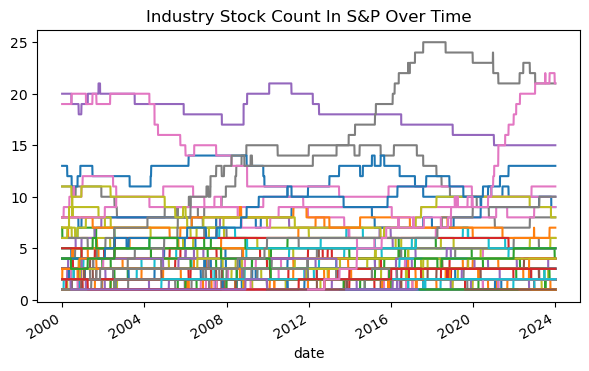

In [172]:
sp500_used.groupby(['industry_code','date'])['permno'].count().unstack().T.plot(
    title='Industry Stock Count In S&P Over Time',
    legend=False,
    figsize=(7,4)
)
plt.show()


### Save cleaned data and info relevant for future analysis

In [175]:
# Packing important inputs for later analysis for saving
data_useful_info_dic={}

data_useful_info_dic['useful_columns_raw'] = useful_columns
data_useful_info_dic['name_map'] = name_map
data_useful_info_dic['time_columns'] = time_columns
data_useful_info_dic['identifier_columns'] = identifier_columns
data_useful_info_dic['categorical_columns'] = categorical_columns
data_useful_info_dic['numerical_columns'] = numerical_columns

In [176]:
with open('./data-used/data_useful_info_dic.pkl','wb') as f:
    pickle.dump(data_useful_info_dic, f)

with open('./data-used/sp500_used.pkl','wb') as f:
    pickle.dump(sp500_used, f)

# sp500_crsp.to_csv('./data-used/sp500_crsp.csv')
# sp500_crsp_ccm.to_csv('./data-used/sp500_crsp_ccm.csv')
sp500_used.to_csv('./data-used/sp500_used.csv')

# Other plots for presentation (may not be permanent)

In [188]:
!pip install yfinance --quiet

[*********************100%***********************]  1 of 1 completed


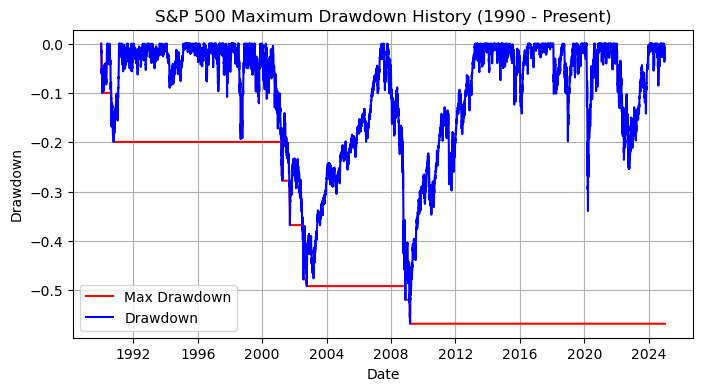

In [189]:
import yfinance as yf

# Download S&P 500 historical data
sp500_mkt = yf.download('^GSPC', start='1990-01-01', end='2024-12-31')
sp500_mkt = sp500_mkt.droplevel(1, axis=1)

# Calculate daily returns
sp500_mkt['return'] = sp500_mkt['Close'].pct_change()

def mmd_cal(df):
    df['cum_rtn']=(1+df['return']).cumprod()
    df['drawdown'] = (df['cum_rtn']-df['cum_rtn'].cummax())/df['cum_rtn'].cummax()
    df['max_drawdown'] =  df['drawdown'].cummin()
    return df

sp500_mkt = mmd_cal(sp500_mkt)

# Plot the maximum drawdown history
plt.figure(figsize=(8, 4))
plt.plot(sp500_mkt['max_drawdown'], label='Max Drawdown', color='red')
plt.plot(sp500_mkt['drawdown'], label='Drawdown', color='blue')
plt.title('S&P 500 Maximum Drawdown History (1990 - Present)')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid()
plt.show()